In [1]:
%matplotlib inline

from collections import defaultdict

import random as rn
import copy as copy

import time

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('imbd_cleaned.csv')

X = df.select_dtypes(include=['number'])
X = X.drop(['averageRating'], axis = 1)
features_name = X.columns
X = X.values
y = np.array(df['rating'])

## Data Partitioning

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
import numpy as np

def convert_interval_to_numeric(interval):
    # Rimuovi le parentesi e dividi per la virgola
    lower, upper = interval[1:-1].split(', ')
    # Converti in float e calcola il punto medio
    return int(lower)

# Applica la conversione a y_train e y_test
y_train_numeric = np.array([convert_interval_to_numeric(interval) for interval in y_train])
y_test_numeric = np.array([convert_interval_to_numeric(interval) for interval in y_test])

print("y_train convertito:", y_train_numeric)
print("y_test convertito:", y_test_numeric)

y_train convertito: [6 7 7 ... 6 8 6]
y_test convertito: [8 7 6 ... 5 4 5]


In [8]:
from xgboost import XGBClassifier

In [9]:

# Definisci il modello con i migliori iperparametri trovati
best_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='exact',
    random_state=42,
    subsample=0.8,
    reg_lambda=10,
    reg_alpha=1,
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.8, probability=True
)

# Addestra il modello con i dati di addestramento
best_model.fit(X_train, y_train_numeric)

# evals_result = best_model.evals_result()
# epochs = len(evals_result['validation_0']['logloss'])
# print("Numero medio di epoch del miglior modello:", epochs)

c:\Users\Tommaso\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:07:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "probability" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [10]:
# Supponendo che y_pred e y_test_numeric siano già definiti
y_pred = best_model.predict(X_test)

# Definire gli intervalli
intervals = ['(0,1]', '(1,2]', '(2,3]', '(3,4]', '(4,5]', '(5,6]', '(6,7]', '(7,8]', '(8,9]', '(9,10]']

# Stampare l'accuratezza
print('Accuracy %s' % accuracy_score(y_test_numeric, y_pred))

# Stampare il F1-score
print('F1-score %s' % f1_score(y_test_numeric, y_pred, average=None))

print(classification_report(y_test_numeric, y_pred, target_names=intervals))

Accuracy 0.41212882389880684
F1-score [0.34285714 0.11111111 0.07179487 0.09007506 0.19858926 0.30448598
 0.38063034 0.55058657 0.19477866 0.22289157]
              precision    recall  f1-score   support

       (0,1]       0.67      0.23      0.34        26
       (1,2]       0.43      0.06      0.11       141
       (2,3]       0.38      0.04      0.07       353
       (3,4]       0.31      0.05      0.09      1027
       (4,5]       0.38      0.13      0.20      2719
       (5,6]       0.38      0.26      0.30      6372
       (6,7]       0.38      0.38      0.38     11643
       (7,8]       0.43      0.75      0.55     14463
       (8,9]       0.38      0.13      0.19      6563
      (9,10]       0.49      0.14      0.22      1281

    accuracy                           0.41     44588
   macro avg       0.42      0.22      0.25     44588
weighted avg       0.40      0.41      0.37     44588



In [11]:
# Output grezzo da XGBoost
importance_raw = best_model.get_booster().get_score(importance_type='gain')

# Rinomina le chiavi con i nomi veri
importance_named = {
    features_name[int(k[1:])]: v
    for k, v in importance_raw.items()
}
# Ordina le caratteristiche in base all'importanza
importance_sorted = sorted(importance_named.items(), key=lambda x: x[1], reverse=True)
# Estrai i nomi delle caratteristiche e i valori di importanza
features, importance_values = zip(*importance_sorted)
#stampare l'importanza delle caratteristiche
print("Importanza delle caratteristiche:")
for feature, importance in importance_sorted:
    print(f"{feature}: {importance:.4f}")

Importanza delle caratteristiche:
runtimeMinutes: 3.4543
numRegions: 3.0727
isAdult: 2.9257
startYear: 2.5891
awardWins: 2.5315
canHaveEpisodes: 2.2067
AwNmExWins: 1.9296
numVotes: 1.8859
writerCredits: 1.8052
directorsCredits: 1.8011
quotesTotal: 1.7649
totalCredits: 1.5335
userReviewsTotal: 1.5175
externalLinks: 1.5159
companiesNumber: 1.4468
castNumber: 1.4386
totalImages: 1.3280
criticReviewsTotal: 1.3248
totalVideos: 1.0799


In [12]:
import shap

In [13]:
fitted_bm = best_model.fit(X_train, y_train_numeric)

c:\Users\Tommaso\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:09:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "probability" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
shap_explainer = shap.TreeExplainer(fitted_bm)
shap_vals = shap_explainer.shap_values(X_test)

In [15]:
# Ricostruisci X_test come DataFrame
X_test_df = pd.DataFrame(X_test, columns=features_name)

In [16]:
# shap_vals ha shape (n_samples, n_features, n_classes)
# Lo convertiamo in lista di array 2D
shap_vals_per_class = [shap_vals[:, :, i] for i in range(shap_vals.shape[2])]


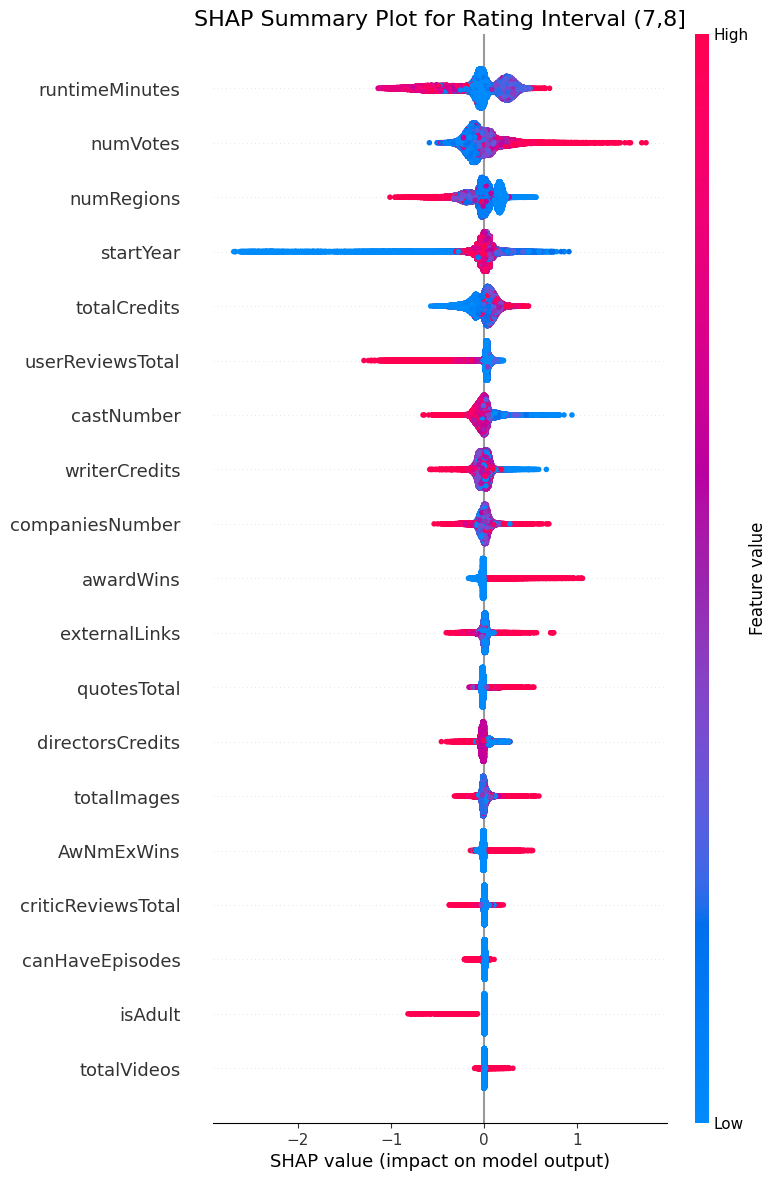

In [17]:
# Ora puoi usare il summary_plot per una classe specifica
classe_target = 7  # o quella che vuoi

shap.summary_plot(
    shap_vals_per_class[classe_target],
    X_test,
    plot_type="dot",  # o "dot"
    show=False,
    feature_names=features_name,
)

# Ridimensiona e mostra
fig = plt.gcf()
fig.set_size_inches(8, 12)
plt.title(f"SHAP Summary Plot for Rating Interval {intervals[classe_target]}", fontsize=16)
plt.show()

In [18]:
# Questo codice serve a filtrare gli errori del modello XGBoost in base alla confidenza delle predizioni e alla classe reale.

# 2. Imposta soglia di probabilità
max_prob = 0.75  # include solo predizioni con confidenza <= 75%
min_prob = 0.0   # esclude predizioni con confidenza < 0%

# 3. Imposta classe reale da filtrare (es. '(8,9]') o None
target_class = '(7,8]'  # puoi mettere None per non filtrare

# 4. Predizioni e probabilità
y_pred_numeric = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)

# 5. Converti predizioni e etichette vere in stringa leggibile
preds = [intervals[i] for i in y_pred_numeric]
true_labels = [intervals[i] for i in y_test_numeric]  # ATTENZIONE: serve y_test_numeric!

# 6. Costruisci DataFrame delle probabilità per ogni classe
probs_df = pd.DataFrame(probs, columns=intervals)

# 7. Aggiungi predizioni, etichette reali e confidenza della classe predetta
prob_pred_class = [
    row[pred] for row, pred in zip(probs_df.to_dict(orient="records"), preds)
]

results = probs_df.copy()
results["Classe_predetta"] = preds
results["Classe_reale"] = true_labels
results["Probabilità_predetta"] = prob_pred_class

# 8. Filtra solo gli errori
errori = results[results["Classe_predetta"] != results["Classe_reale"]]

# 9. Se richiesta, filtra solo per una classe reale specifica
if target_class is not None:
    errori = errori[errori["Classe_reale"] == target_class]

# 10. Filtra per soglia di probabilità
errori_filtrati = errori[
    (errori["Probabilità_predetta"] >= min_prob) &
    (errori["Probabilità_predetta"] <= max_prob)
]

# 11. Ordina per confidenza e seleziona i 10 peggiori errori "sicuri"
errori_top10 = errori_filtrati.sort_values(by="Probabilità_predetta", ascending=False).head(10)

# 12. Stampa risultato
if errori_top10.empty:
    print("⚠️  Nessun errore trovato con le condizioni specificate.")
else:
    print(f"🧪 I 10 errori più 'sicuri' (confidenza ≤ {max_prob*100:.0f}%)")
    if target_class:
        print(f"🎯 Classe reale selezionata: {target_class}")
    display(errori_top10)


🧪 I 10 errori più 'sicuri' (confidenza ≤ 75%)
🎯 Classe reale selezionata: (7,8]


,"(0,1]","(1,2]","(2,3]","(3,4]","(4,5]","(5,6]","(6,7]","(7,8]","(8,9]","(9,10]",Classe_predetta,Classe_reale,Probabilità_predetta
14536,0.000054,0.000302,0.001631,0.002110,0.012311,0.095104,0.748065,0.134814,0.005184,0.000425,"(6,7]","(7,8]",0.748065
35318,0.000027,0.000222,0.000629,0.002167,0.008242,0.012568,0.057747,0.170736,0.746204,0.001459,"(8,9]","(7,8]",0.746204
34419,0.000018,0.000121,0.000355,0.001630,0.008504,0.147061,0.745281,0.096179,0.000755,0.000095,"(6,7]","(7,8]",0.745281
42761,0.000049,0.000532,0.000177,0.014444,0.003881,0.011597,0.034180,0.167549,0.744431,0.023159,"(8,9]","(7,8]",0.744431
34598,0.000082,0.000457,0.003244,0.002220,0.017194,0.103878,0.744186,0.126216,0.002283,0.000242,"(6,7]","(7,8]",0.744186
7995,0.000024,0.000127,0.000437,0.001718,0.001297,0.003547,0.017450,0.224320,0.740184,0.010894,"(8,9]","(7,8]",0.740184
7742,0.000035,0.000183,0.001436,0.014857,0.012961,0.058274,0.738725,0.165055,0.008102,0.000372,"(6,7]","(7,8]",0.738725
10734,0.000009,0.000212,0.000290,0.000124,0.000325,0.001033,0.012057,0.240865,0.733818,0.011266,"(8,9]","(7,8]",0.733818
30081,0.000021,0.000451,0.003869,0.001973,0.006020,0.008113,0.018460,0.225689,0.733106,0.002297,"(8,9]","(7,8]",0.733106
38074,0.000024,0.000119,0.002116,0.001549,0.017170,0.210045,0.733015,0.034203,0.001637,0.000124,"(6,7]","(7,8]",0.733015


In [33]:
# 1. Scegli l'indice dell'istanza da spiegare
i2e = 14536  # Cambia questo con l’indice desiderato

In [34]:
# Estrai la riga come Series
record = X_test_df.iloc[i2e]

# Stampa i valori feature per feature
print(f"🎯 Valori delle feature per l'istanza {i2e}:\n")
for feature_name, value in record.items():
    print(f"{feature_name}: {value}")

🎯 Valori delle feature per l'istanza 14536:

startYear: 0.16677621367353587
runtimeMinutes: 1.6350489118334168
awardWins: 4.817255759999603
numVotes: 2.9609645992768625
totalImages: 1.9472492311571996
totalVideos: 2.354668236636699
totalCredits: 2.2920741069256567
criticReviewsTotal: 4.6400213406382
AwNmExWins: 5.105496067663958
canHaveEpisodes: -0.2740371571608186
isAdult: -0.13686604032824912
numRegions: 2.3624488265366175
userReviewsTotal: 4.217958471313383
castNumber: 0.48175162140639155
companiesNumber: 2.7481016270934324
externalLinks: 3.1721364514937176
writerCredits: 0.3482371866222334
directorsCredits: 0.25305782301642715
quotesTotal: 2.1766500716352883


In [35]:
# 2. Istanza da spiegare (formato DataFrame e Series)
x_instance_df = X_test_df.iloc[[i2e]]   # DataFrame (1, n_features)
x_instance_series = X_test_df.iloc[i2e] # Series (n_features,)

# 3. Classe predetta dall’istanza
predicted_class_i2e = best_model.predict(x_instance_df)[0]
predicted_class_label = intervals[predicted_class_i2e]

print(f"✅ Classe predetta per l’istanza {i2e}: {predicted_class_label} (classe {predicted_class_i2e})")

# 4. Ottieni valori SHAP per la classe predetta
shap_values_instance = shap_vals_per_class[predicted_class_i2e][i2e]

# 5. FORCE PLOT (interattivo)
shap.initjs()
shap.force_plot(
    base_value=shap_explainer.expected_value[predicted_class_i2e],
    shap_values=shap_values_instance,
    features=x_instance_series,
    feature_names=features_name
)

✅ Classe predetta per l’istanza 14536: (6,7] (classe 6)


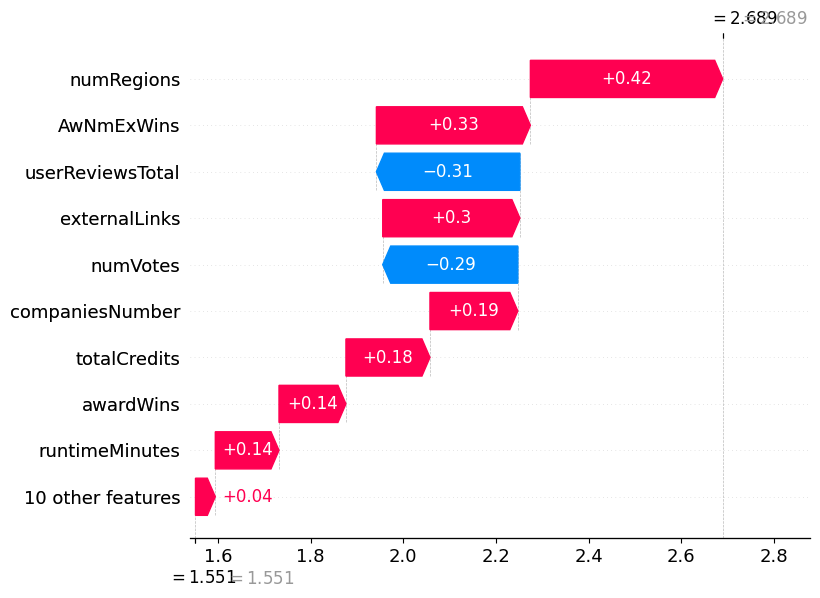

In [36]:
from shap.plots._waterfall import waterfall_legacy

# Waterfall plot (statico, utile anche se non sei in Jupyter)
shap.plots._waterfall.waterfall_legacy(
    shap_explainer.expected_value[predicted_class_i2e],
    shap_values_instance,
    feature_names=features_name
)

In [19]:
#Questo codice serve a filtrare i record classificati correttamente da un modello XGBoost in base alla confidenza delle predizioni e alla classe reale.

# 2. Parametri di filtro
max_prob = 0.75    # massimo livello di confidenza
min_prob = 0.0     # minimo livello di confidenza (opzionale)
target_class = '(7,8]'   # o None per tutte

# 3. Predizioni e probabilità
y_pred_numeric = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)

# 4. Conversione in etichette stringa leggibili
preds = [intervals[i] for i in y_pred_numeric]
true_labels = [intervals[i] for i in y_test_numeric]  # ⚠️ Serve y_test_numeric

# 5. Costruzione DataFrame
probs_df = pd.DataFrame(probs, columns=intervals)

# 6. Aggiunta colonne predizione, reale e probabilità associata alla predizione
prob_pred_class = [
    row[pred] for row, pred in zip(probs_df.to_dict(orient="records"), preds)
]

results = probs_df.copy()
results["Classe_predetta"] = preds
results["Classe_reale"] = true_labels
results["Probabilità_predetta"] = prob_pred_class

# 7. Filtra solo i record classificati correttamente
corretti = results[results["Classe_predetta"] == results["Classe_reale"]]

# 8. Filtro opzionale sulla classe reale
if target_class is not None:
    corretti = corretti[corretti["Classe_reale"] == target_class]

# 9. Filtro sul range di probabilità
corretti_filtrati = corretti[
    (corretti["Probabilità_predetta"] >= min_prob) &
    (corretti["Probabilità_predetta"] <= max_prob)
]

# 10. Ordina e seleziona i top 10
corretti_top10 = corretti_filtrati.sort_values(
    by="Probabilità_predetta", ascending=False
).head(10)

# 11. Mostra il risultato
if corretti_top10.empty:
    print("⚠️  Nessun record corretto trovato con le condizioni specificate.")
else:
    print(f"✅ I 10 record classificati correttamente con confidenza ≤ {max_prob*100:.0f}%")
    if target_class:
        print(f"🎯 Classe reale selezionata: {target_class}")
    display(corretti_top10)

✅ I 10 record classificati correttamente con confidenza ≤ 75%
🎯 Classe reale selezionata: (7,8]


,"(0,1]","(1,2]","(2,3]","(3,4]","(4,5]","(5,6]","(6,7]","(7,8]","(8,9]","(9,10]",Classe_predetta,Classe_reale,Probabilità_predetta
24270,0.000027,0.000230,0.000539,0.000718,0.001452,0.005396,0.096793,0.749685,0.136670,0.008490,"(7,8]","(7,8]",0.749685
27516,0.000026,0.000165,0.000173,0.001059,0.003489,0.011848,0.117794,0.749617,0.112207,0.003621,"(7,8]","(7,8]",0.749617
6479,0.000039,0.000075,0.000752,0.001974,0.007852,0.016813,0.121664,0.749616,0.100483,0.000733,"(7,8]","(7,8]",0.749616
15673,0.000014,0.000095,0.000627,0.000523,0.002921,0.019752,0.164986,0.749531,0.058980,0.002571,"(7,8]","(7,8]",0.749531
12117,0.000015,0.000170,0.000183,0.002256,0.003269,0.014727,0.145406,0.749531,0.083453,0.000990,"(7,8]","(7,8]",0.749531
12701,0.000021,0.000065,0.000125,0.000608,0.000916,0.004110,0.056004,0.749410,0.182860,0.005881,"(7,8]","(7,8]",0.749410
8727,0.000016,0.000211,0.000934,0.001549,0.005426,0.023030,0.110270,0.749335,0.107323,0.001906,"(7,8]","(7,8]",0.749335
19357,0.000038,0.000459,0.001752,0.013291,0.008292,0.020352,0.108964,0.749078,0.095254,0.002520,"(7,8]","(7,8]",0.749078
43148,0.000017,0.000162,0.000301,0.000687,0.001408,0.007798,0.106934,0.748523,0.133337,0.000834,"(7,8]","(7,8]",0.748523
4089,0.000023,0.000085,0.000214,0.000525,0.000933,0.005393,0.041072,0.748476,0.202023,0.001256,"(7,8]","(7,8]",0.748476


In [37]:
# 1. Scegli l'indice dell'istanza da spiegare
i2e = 24270  # Cambia questo con l’indice desiderato
# Estrai la riga come Series
record = X_test_df.iloc[i2e]

In [38]:

# Stampa i valori feature per feature
print(f"🎯 Valori delle feature per l'istanza {i2e}:\n")
for feature_name, value in record.items():
    print(f"{feature_name}: {value}")

🎯 Valori delle feature per l'istanza 24270:

startYear: 1.0083268408097381
runtimeMinutes: 0.27726325770536997
awardWins: -0.2553190401706802
numVotes: 1.1600296825505327
totalImages: 0.22903407119344518
totalVideos: -0.25318800942716857
totalCredits: 5.553657822915173
criticReviewsTotal: 0.4473883431345564
AwNmExWins: -0.270356608782543
canHaveEpisodes: -0.2740371571608186
isAdult: -0.13686604032824912
numRegions: -0.564182179025809
userReviewsTotal: -0.5799086723639202
castNumber: 1.1550109793985515
companiesNumber: 0.316075242160257
externalLinks: -0.14329913262377683
writerCredits: 1.119506230143265
directorsCredits: 1.4309824771889923
quotesTotal: -0.3435228021711699


In [39]:
# 2. Istanza da spiegare (formato DataFrame e Series)
x_instance_df = X_test_df.iloc[[i2e]]   # DataFrame (1, n_features)
x_instance_series = X_test_df.iloc[i2e] # Series (n_features,)

# 3. Classe predetta dall’istanza
predicted_class_i2e = best_model.predict(x_instance_df)[0]
predicted_class_label = intervals[predicted_class_i2e]

print(f"✅ Classe predetta per l’istanza {i2e}: {predicted_class_label} (classe {predicted_class_i2e})")

# 4. Ottieni valori SHAP per la classe predetta
shap_values_instance = shap_vals_per_class[predicted_class_i2e][i2e]

# 5. FORCE PLOT (interattivo)
shap.initjs()
shap.force_plot(
    base_value=shap_explainer.expected_value[predicted_class_i2e],
    shap_values=shap_values_instance,
    features=x_instance_series,
    feature_names=features_name
)

✅ Classe predetta per l’istanza 24270: (7,8] (classe 7)


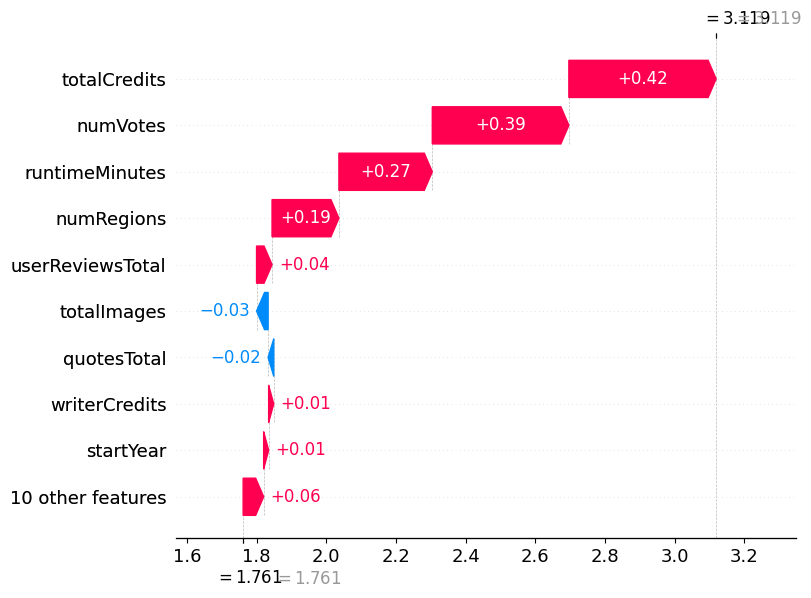

In [40]:
from shap.plots._waterfall import waterfall_legacy

# Waterfall plot (statico, utile anche se non sei in Jupyter)
shap.plots._waterfall.waterfall_legacy(
    shap_explainer.expected_value[predicted_class_i2e],
    shap_values_instance,
    feature_names=features_name
)

In [ ]:
#PROVA GRAFICO CORRETTO

# === Ottieni la predizione per quell’istanza ===
predicted_class_idx = best_model.predict(X_test[i2e].reshape(1, -1))[0]
predicted_class_label = intervals[predicted_class_idx]

# === Ottieni i valori SHAP e le feature per quella istanza ===
expl = shap.Explanation(
    values=shap_vals[i2e, :, predicted_class_idx],
    base_values=shap_explainer.expected_value[predicted_class_idx],
    data=X_test_df.iloc[i2e],
    feature_names=features_name
)

# === Mostra il waterfall plot ===
plt.rcParams['text.usetex'] = False  # disabilita LaTeX per evitare bug visuale
shap.plots.waterfall(expl, show=False)

# === Aggiungi titolo leggibile ===
plt.title(f"SHAP Waterfall Plot\nIstanza {i2e} – Classe predetta: {predicted_class_label}\nE[f(x)] = {expl.base_values:.3f}", fontsize=12)

plt.show()


NameError: name 'best_model' is not defined